In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pybedtools import BedTool
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import re
from plotting_utils import figure_path, label_sample
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plasma_miRNA = \
"""hsa-let-7a	hsa-miR-148a	hsa-miR-221	hsa-miR-338-3p
hsa-let-7b	hsa-miR-148b	hsa-miR-222	hsa-miR-339-3p
hsa-let-7b∗	hsa-miR-150	hsa-miR-223	hsa-miR-342-3p
hsa-let-7d	hsa-miR-151-5p	hsa-miR-223∗	hsa-miR-363
hsa-let-7d∗	hsa-miR-152	hsa-miR-23a	hsa-miR-374b
hsa-let-7f	hsa-miR-15a	hsa-miR-23b	hsa-miR-375
hsa-let-7g	hsa-miR-15b	hsa-miR-24	hsa-miR-378
hsa-let-7i	hsa-miR-15b∗	hsa-miR-25	hsa-miR-423-3p
hsa-miR-101	hsa-miR-16	hsa-miR-26b	hsa-miR-423-5p
hsa-miR-103	hsa-miR-16-2∗	hsa-miR-27a	hsa-miR-424
hsa-miR-106a	hsa-miR-17	hsa-miR-27b	hsa-miR-425
hsa-miR-106b	hsa-miR-181a	hsa-miR-28-3p	hsa-miR-425∗
hsa-miR-107	hsa-miR-185	hsa-miR-28-5p	hsa-miR-451
hsa-miR-122	hsa-miR-186	hsa-miR-29a	hsa-miR-484
hsa-miR-125a-5p	hsa-miR-18a	hsa-miR-29b	hsa-miR-486-5p
hsa-miR-125b	hsa-miR-18b	hsa-miR-29c	hsa-miR-495
hsa-miR-126	hsa-miR-191	hsa-miR-301a	hsa-miR-502-3p
hsa-miR-128	hsa-miR-192	hsa-miR-30b	hsa-miR-505
hsa-miR-130a	hsa-miR-195	hsa-miR-30c	hsa-miR-532-3p
hsa-miR-133a	hsa-miR-199a-3p	hsa-miR-30d	hsa-miR-532-5p
hsa-miR-139-5p	hsa-miR-199a-5p	hsa-miR-30e	hsa-miR-574-3p
hsa-miR-140-3p	hsa-miR-19a	hsa-miR-30e∗	hsa-miR-584
hsa-miR-140-5p	hsa-miR-19b	hsa-miR-32	hsa-miR-629
hsa-miR-142-3p	hsa-miR-20a	hsa-miR-320a	hsa-miR-652
hsa-miR-142-5p	hsa-miR-20b	hsa-miR-320b	hsa-miR-92a
hsa-miR-143	hsa-miR-21	hsa-miR-324-3p	hsa-miR-93
hsa-miR-144	hsa-miR-210	hsa-miR-324-5p	hsa-miR-93∗
hsa-miR-144∗	hsa-miR-215	hsa-miR-328	hsa-miR-99a
hsa-miR-145	hsa-miR-22	hsa-miR-331-3p	hsa-miR-99b
hsa-miR-146a	hsa-miR-22∗	hsa-miR-335"""

miRNA_list = plasma_miRNA.split()
miRNA_list = map(lambda x: re.sub('^hsa-|miR-|-[35]p$','', x), miRNA_list)
miRNA_list = map(lambda x: 'MIR' + x.upper().replace('T-7','T7').rstrip('∗'), miRNA_list)
plasma_miRNA_list = pd.DataFrame({'name': list(miRNA_list),
                                  'is_plasma':'red'}) \
    .assign(name = lambda d: np.where(d.name.str.contains('LET'),
                                     d.name.str.replace('[0-9]$',''),
                                     d.name))
plasma_miRNA_list.head()

,name,is_plasma
0,MIRLET7A,red
1,MIR148A,red
2,MIR221,red
3,MIR338,red
4,MIRLET7B,red


In [4]:
def count_miRNA(sample_file = 'unfragmented.bed.gz', mature=True):
    miRNA_bed = '/stor/work/Lambowitz/ref/hg19/new_genes/miRNA.bed'
    sample_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bed'
    fragment_bed = sample_path +'/'+ sample_file
    
    if mature:
        fragment_bed = BedTool(fragment_bed)\
            .filter(lambda x: x.end - x.start < 30)
            
            
    fragments = BedTool(fragment_bed)
    
    
    miRNA_cov = BedTool().coverage(a = miRNA_bed,
              b = fragments,
             s = True, 
             f = 0.1,
             F = 0.8,
             counts=True)
    
    return miRNA_cov\
        .to_dataframe()\
        .sort_values('itemRgb', ascending=False)
        
def merge_dfs(x,y):
    return x.merge(y, how='outer')

def make_cpm(df):
    for col in df.columns:
        df[col] = df[col]/df[col].sum() * 1e6
    return df

In [5]:
mature_count = count_miRNA(mature=True)
mature_count.head()

***** WARNING: File /tmp/pybedtools.0pxkwon_.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	3906	3933	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.0pxkwon_.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	3906	3933	UMI_1_1	0	+



,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb
2904,chrX,65238712,65238821,MIR223,0,+,miRNA,ENSG00000207939.1,95
1296,chr8,41517959,41518026,MIR486,0,+,miRNA,ENSG00000221035.1,31
2366,chr17,28444097,28444190,MIR423,0,+,miRNA,ENSG00000199071.2,29
2409,chr17,57918627,57918698,MIR21,0,+,miRNA,ENSG00000199004.1,28
1516,chr9,139565054,139565138,MIR126,0,+,miRNA,ENSG00000199161.1,25


In [6]:
all_count = count_miRNA(mature=False)
all_count.head()

***** WARNING: File /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bed/unfragmented.bed.gz has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	868	10358	UMI_1_1	0	+

***** WARNING: File /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bed/unfragmented.bed.gz has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	868	10358	UMI_1_1	0	+



,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb
2347,chr17,8090493,8090577,MIR3676,0,+,miRNA,ENSG00000266638.1,288
2574,chr19,33667978,33668061,AC008738.2,0,+,miRNA,ENSG00000264355.1,177
968,chr6,28763749,28763812,AL662890.3,0,-,miRNA,ENSG00000265764.1,167
2904,chrX,65238712,65238821,MIR223,0,+,miRNA,ENSG00000207939.1,96
966,chr6,28615974,28616042,AL121932.1,0,-,miRNA,ENSG00000272278.1,50


In [7]:
def plot_miRNA(ax,miRNA_df, title):
    colored_df = miRNA_df\
        .assign(name = lambda d: np.where(d.name.str.contains('LET'),
                                     d.name.str.replace('[0-9]$',''),
                                     d.name))\
        .merge(plasma_miRNA_list, how='left')\
        .fillna('black')\
        .query('itemRgb >0 ')\
        .drop_duplicates()\
        .nlargest(20,'itemRgb')
        
    colored_df.plot.bar('name', 'itemRgb', 
                  color='steelblue',
                 ax = ax)
    ax.set_title(title, size = 15)
    ax.set_xlabel('miRNA')
    ax.set_ylabel('Read count')
    for xt, color in zip(ax.get_xticklabels(),colored_df.is_plasma):
        xt.set_color(color)
    ax.legend().set_visible(False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Written /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/figure/miRNA_counts.pdf


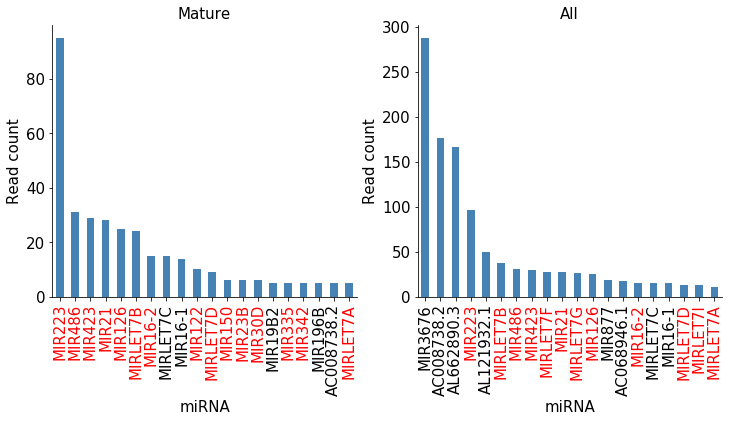

In [8]:
fig = plt.figure(figsize=(12,5))
ax_mature = fig.add_subplot(121)
plot_miRNA(ax_mature, mature_count, 'Mature')

ax_all = fig.add_subplot(122)
plot_miRNA(ax_all, all_count, 'All')
sns.despine()
figurename = figure_path + '/miRNA_counts.pdf' 
fig.savefig(figurename, bbox_inches = 'tight')
print('Written %s' %figurename)

In [9]:
def plot_heatmap(top_n=50, mature=False):
    sample_files = ['unfragmented.bed.gz', 
                'alkaline.bed.gz',
                'all.bed.gz',
                'fragmented.bed.gz']
    all_mirna = []
    for sample_file in sample_files:
        samplename = sample_file.replace('.bed.gz','')
        all_mirna.append(count_miRNA(sample_file=sample_file, mature=mature)\
                        .rename(columns = {'itemRgb':samplename}))
        
    all_mirna_df = reduce(merge_dfs, all_mirna)
    
    plasma_miRNA = set(plasma_miRNA_list.name.values.tolist())

    cpm_df = all_mirna_df\
        .filter(regex='name|frag|alk|all')\
        .set_index('name')\
        .pipe(lambda d: make_cpm(d))\
        .fillna(0)\
        .transform(lambda x: np.log2(x+1))\
        .nlargest(top_n, 'unfragmented')
    p = sns.clustermap(cpm_df, cmap = 'viridis')
    ax = p.ax_heatmap
    ax.set_yticks(range(top_n))
    
    
    yt = ax.set_yticklabels(cpm_df.index[:top_n])
    for yt in ax.get_yticklabels():
        mirna = yt.get_text()
        if 'LET' in mirna:
            mirna = re.sub('[0-9]$','',mirna)
        if yt.get_text() in plasma_miRNA:
            yt.set_color('red')
    return all_mirna_df

***** WARNING: File /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bed/unfragmented.bed.gz has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	868	10358	UMI_1_1	0	+

***** WARNING: File /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bed/unfragmented.bed.gz has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	868	10358	UMI_1_1	0	+

***** WARNING: File /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bed/alkaline.bed.gz has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	2561	2646	UMI_1_1	0	+

***** WARNING: File /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bed/alkaline.bed.gz has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	2561	2646	UMI_1_1	0	+

***** WARNING: File /stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bed/all.bed.gz has inconsistent naming convention for record:
gi|555

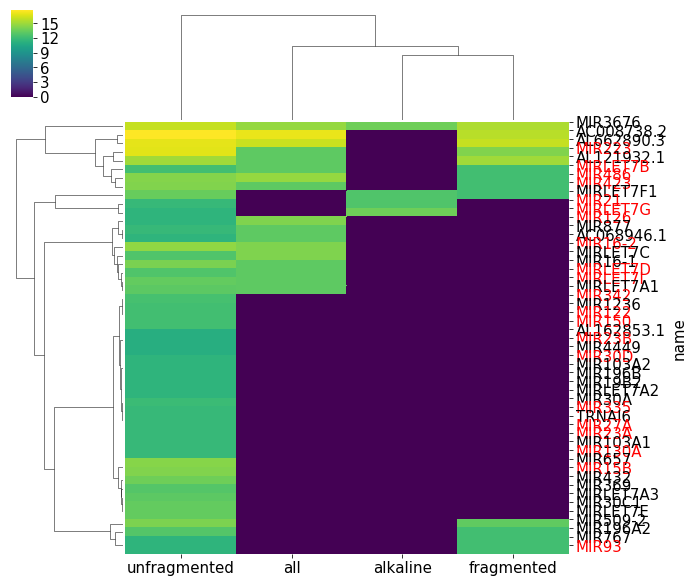

In [10]:
all_mirna_df = plot_heatmap()

***** WARNING: File /tmp/pybedtools.6gy7d9_m.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	3906	3933	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.6gy7d9_m.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	3906	3933	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.i9kr1ebb.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	27987	28007	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.i9kr1ebb.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	27987	28007	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.genjx2wd.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	8954	8973	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.genjx2wd.tmp has inconsistent naming convention for record:
gi|555853|gb|U13369.1|HSU13369	8954	8973	UMI_1_1	0	+

***** WARNING: File /tmp/pybedtools.n0roe_mw.tmp has inconsistent naming convention for record:


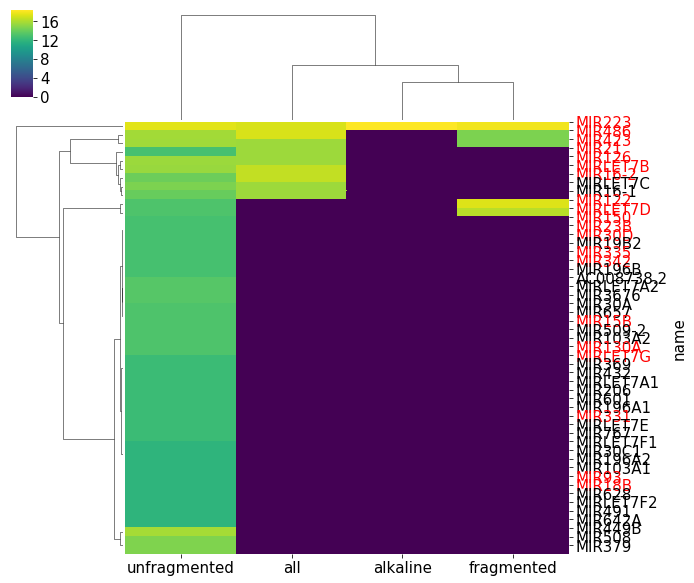

In [11]:
mature_mirna_df = plot_heatmap(mature=True)

In [22]:
def heatmap_miRNA(mirna_df, ax, title):
    top_n = 50
    cpm_df = mirna_df \
        .filter(regex='name|frag|alk|all')\
        .set_index('name')\
        .pipe(lambda d: make_cpm(d))\
        .fillna(0)\
        .nlargest(top_n, 'unfragmented')\
        .transform(lambda x: np.log2(x+1))\
        .filter(regex = 'unfra|all') \
        .rename(columns = label_sample)
    
    plasma_miRNA = set(plasma_miRNA_list.name.values.tolist())


    sns.heatmap(cpm_df, 
            ax = ax,
           cmap = 'viridis')
    ax.set_yticks(np.arange(top_n) + 0.5)
    yt = ax.set_yticklabels(cpm_df.index[:top_n])
    for yt in ax.get_yticklabels():
        mirna = yt.get_text()
        if 'LET' in mirna:
            mirna = re.sub('[0-9]$','',mirna)
        if mirna in plasma_miRNA:
            yt.set_color('red')
        
    ax.set_ylabel('miRNA')
    ax.set_title(title, size=15)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


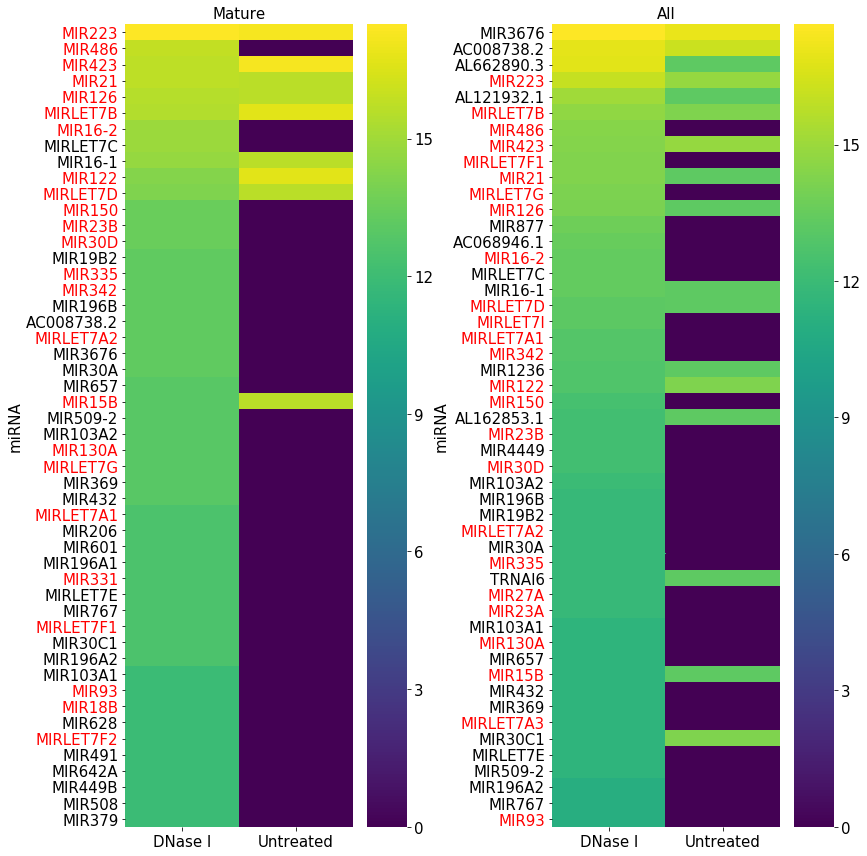

In [24]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

heatmap_miRNA(mature_mirna_df, ax, 'Mature')
heatmap_miRNA(all_mirna_df, ax2, 'All')
fig.tight_layout()